In [1]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import re
data = pd.read_csv('merged_conversations.csv')
data

,SourceType,SourceURL,SourceAuthor,SourceTitle,Prompt,Answer,ListOfCode,ChatgptURL,DateOfConversation,Model,NumberOfPrompts,TokensOfPrompts,TokensOfAnswers
0,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,"Hey, I am working on writing a technical docum...","Of course, I'd be happy to help you translate ...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
1,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,I noticed that I've already have translated co...,"Absolutely, I'd be glad to help you refine the...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
2,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,# Working Principle of dae\n\n[**简体中文**](../zh...,Working Principle of dae简体中文 | Englishdae oper...,[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
3,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,Is the gramma refined?,"Yes, the grammar has been refined in the provi...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
4,pull request,https://github.com/FlorianWoelki/obsidian-symb...,sharshuv-quotient,Fix constructor being converted to undefined,I have this code:\n\nconst characterMap: Chara...,This issue arises because object property look...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",https://chat.openai.com/share/acece149-6d4b-45...,"August 23, 2023",Default,2,223,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18753,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Let's work this out in a step-by-step way to b...,"Sure, we can use a similar approach to the one...",[],https://chat.openai.com/share/62a8cdf2-6de6-49...,"May 27, 2023",Default,2,91,528
18754,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Who is Obie Fernandez and what is he famous for?,Obie Fernandez is a well-known figure in the f...,[],https://chat.openai.com/share/e42ed290-4b31-4d...,"May 27, 2023",Default,2,24,318
18755,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Sure go ahead. I'm interested in his other pur...,Obie Fernandez is a Ruby and Ruby on Rails dev...,[],https://chat.openai.com/share/e42ed290-4b31-4d...,"May 27, 2023",Default,2,24,318
18756,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,"What is Hacker News, what can you tell me abou...",Hacker News is a social news website focusing ...,[],https://chat.openai.com/share/66169853-d00a-4b...,"May 27, 2023",Default,1,17,390


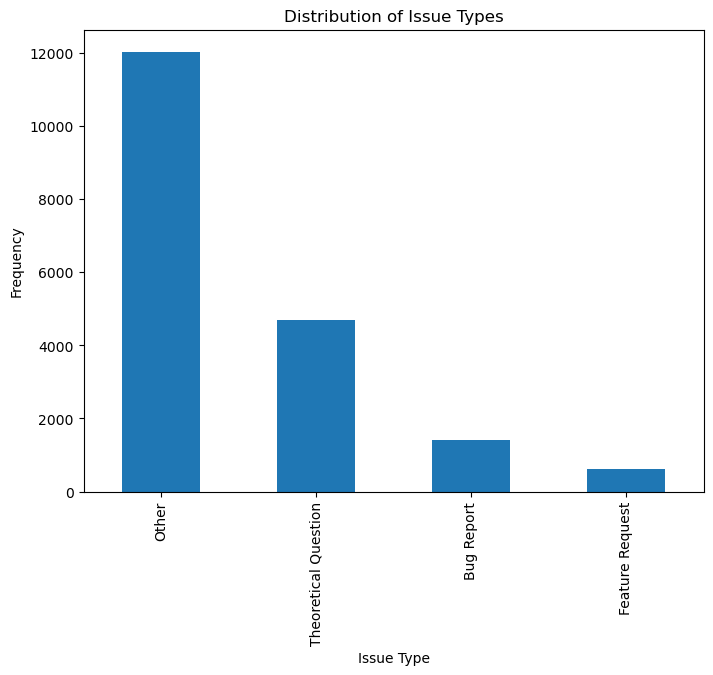

In [2]:

data['Prompt'] = data['Prompt'].fillna('').astype(str)

def classify_issue(prompt):
    prompt = prompt.lower()
    if 'bug' in prompt or 'error' in prompt:
        return 'Bug Report'
    elif 'feature' in prompt or 'enhance' in prompt:
        return 'Feature Request'
    elif 'how to' in prompt or '?' in prompt:
        return 'Theoretical Question'
    else:
        return 'Other'


data['IssueType'] = data['Prompt'].apply(classify_issue)

issue_counts = data['IssueType'].value_counts()
plt.figure(figsize=(8, 6))
issue_counts.plot(kind='bar')
plt.title('Distribution of Issue Types')
plt.xlabel('Issue Type')
plt.ylabel('Frequency')
plt.show()


Most common patterns in prompts:
[('string', 21073), ('you', 12630), ('name', 11768), ('with', 11537), ('1', 8735), ('0', 8639), ('from', 8058), ('s', 7300), ('if', 6811), ('as', 6492), ('are', 5767), ('by', 5737), ('can', 5435), ('item', 5429), ('your', 5402), ('not', 5270), ('be', 5245), ('passage', 5036), ('we', 4819), ('2', 4812)]


<Figure size 1000x600 with 0 Axes>

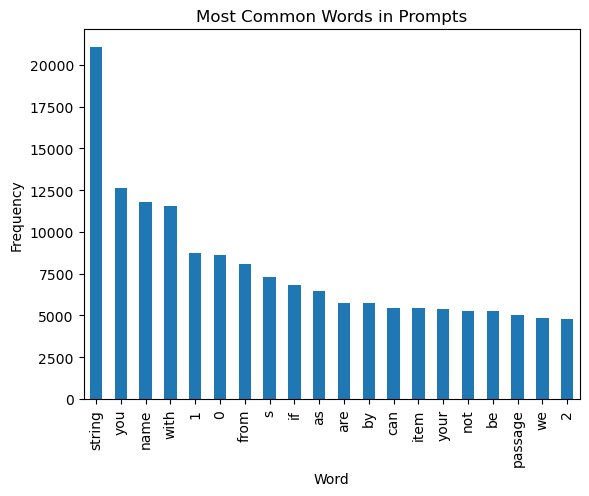

Patterns most correlated with resolution:
Resolved    1.000000
new         0.013154
if          0.011805
text        0.010419
have        0.010229
we          0.009718
are         0.009623
data        0.009122
what        0.008757
user        0.008512
Name: Resolved, dtype: float64


<Figure size 1000x600 with 0 Axes>

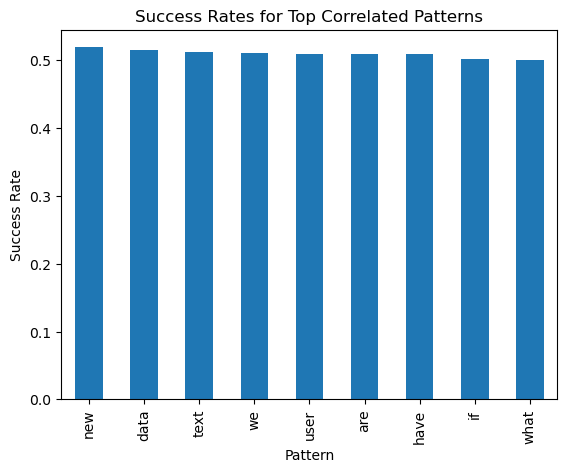

In [3]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt



def preprocess_prompt(prompt):
  
    tokens = re.findall(r'\b\w+\b', str(prompt).lower())  

    stop_words = set(["i", "am", "is", "the", "and", "or", "on", "a", "an", "of", "to", "in", "for", "this", "that", "it"])
    return [word for word in tokens if word not in stop_words]


data['ProcessedPrompt'] = data['Prompt'].fillna('').apply(preprocess_prompt)


all_words = [word for words in data['ProcessedPrompt'] for word in words]
word_counts = Counter(all_words)


print("Most common patterns in prompts:")
print(word_counts.most_common(20))


common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
common_words_df.plot(kind='bar', x='Word', y='Frequency', legend=False)
plt.title('Most Common Words in Prompts')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()


data['ProcessedPromptString'] = data['ProcessedPrompt'].apply(lambda x: ' '.join(x))


vectorizer = CountVectorizer(max_features=50)  
X = vectorizer.fit_transform(data['ProcessedPromptString'])
feature_names = vectorizer.get_feature_names_out()


word_frequencies = pd.DataFrame(X.toarray(), columns=feature_names)


if 'Resolved' in data.columns:
    word_frequencies['Resolved'] = data['Resolved']
else:
    
    word_frequencies['Resolved'] = [1 if i % 2 == 0 else 0 for i in range(len(word_frequencies))]


correlations = word_frequencies.corr()['Resolved'].sort_values(ascending=False)
print("Patterns most correlated with resolution:")
print(correlations.head(10))


top_patterns = correlations.head(10).index


success_rates = {}
for pattern in top_patterns:
    if pattern != 'Resolved': 
        success_rates[pattern] = word_frequencies[word_frequencies[pattern] > 0]['Resolved'].mean()


success_rates_df = pd.DataFrame.from_dict(success_rates, orient='index', columns=['Success Rate'])


plt.figure(figsize=(10, 6))
success_rates_df.sort_values(by='Success Rate', ascending=False).plot(kind='bar', legend=False)
plt.title('Success Rates for Top Correlated Patterns')
plt.xlabel('Pattern')
plt.ylabel('Success Rate')
plt.show()
